Practical Work: Out-of-Distribution Detection, OOD Scoring Methods, and Neural Collapse.

# 1. Training a ResNet18 classifier on CIFAR-100 with PyTorch

In [5]:
import torch
import torchvision
from torchvision.models import resnet18
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [6]:
# Hyperparameters (Improved to reduce overfitting)batch_size = 128  # Increased from 8 to reduce overfittingnum_workers = 8lr = 1e-1  # Increased learning rate for larger batch sizemomentum = 0.9  # Standard momentum value  weight_decay = 5e-4  # Better regularizationepochs = 200  # Increased for better convergence# Skip training and load model locally? If never trained, set to False to train and save the model first.skip_training = True  # True to skip# Random seedtorch.manual_seed(42)

In [7]:

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    transforms.RandomErasing(p=0.2),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])


# Load CIFAR-100
train_set = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)

test_set = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Model configuration
model = resnet18(True)
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(model.fc.in_features, 100)
)
model = model.cuda()

# Optim, Loss, Scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 160], gamma=0.2)

# Training loop
train_losses = []
train_accs = []
test_losses = []
test_accs = []

# Training loop
def train(epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    print(f"Epoch {epoch}: Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}%")
    return epoch_loss, epoch_acc

# Simple Test Loop
def test(epoch):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(test_loader)
    epoch_acc = 100. * correct / total
    print(f"Test Accuracy: {epoch_acc:.2f}%")
    return epoch_loss, epoch_acc

Using device: cuda


/users/eleves-b/2024/huanshan.huang/miniconda3/envs/inf554/lib/python3.12/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/users/eleves-b/2024/huanshan.huang/miniconda3/envs/inf554/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


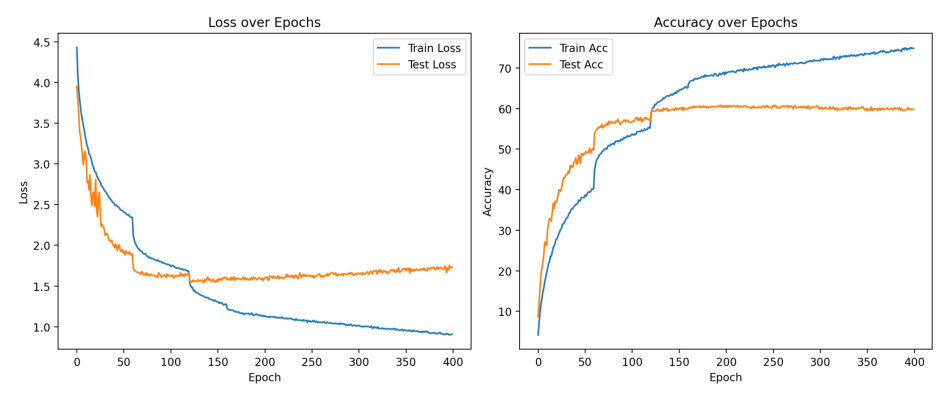

In [8]:
# Load model
if skip_training:  # Change to True to load the model
    try:
        model.load_state_dict(torch.load('resnet18_cifar100.pth', map_location=device))
        plot_path = "training_curves.png"
        img = plt.imread(plot_path)
        plt.figure(figsize=(12, 5))
        plt.imshow(img)
        plt.axis("off")
        plt.show()
    except FileNotFoundError:
        assert False, "Model or training curves not found. Please train the model first."
else:
    # Main training and testing loop
    for epoch in range(epochs):
        train_loss, train_acc = train(epoch)
        test_loss, test_acc = test(epoch)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        scheduler.step()

    # Save model
    torch.save(model.state_dict(), 'resnet18_cifar100.pth')

    # Plotting
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(test_accs, label='Test Acc')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig("training_curves.png", dpi=200, bbox_inches="tight")
    plt.show()





# 2. Implement and compare OOD scores
Implement and compare the following OOD scores:

· Max Softmax Probability (MSP)

· Maximum Logit Score

· Mahalanobis

· Energy Score

· ViM

# 2.1 Max Softmax Probability (MSP). 
If the classifier assigns low maximum probability, it is unsure or the input may be OOD.

Score: the maximum softmax probability
$$s_{max-prob}(x)=\mathop{max}\limits_{c} p(y=c|x)=\mathop{max}\limits_{c} softmax(z_c(x))$$

In [9]:
def msp_score(model, loader):
    model.eval()
    all_scores = []

    with torch.no_grad():
        for data in loader:
            inputs, _ = data
            inputs = inputs.to(device)
            logits = model(inputs)
            probs = F.softmax(logits, dim=1)

            max_probs, _ = torch.max(probs, dim=1)
            
            all_scores.append(max_probs.cpu())
            
    return torch.cat(all_scores)

msp_scores = msp_score(model, test_loader)

print(f"MSP scores: {msp_scores}")

MSP scores: tensor([0.6973, 0.9303, 0.5525,  ..., 0.9999, 0.5125, 0.8073])


# 3. Max Logit technique. 
Logits reflect raw model evidence before the softmax normalization; using logits avoids saturating effects of softmax.
$$s_{max-logit}(x)= \mathop{max}\limits_{c}\ z_c(x)$$

In [10]:
def max_logit_score(model, loader):
    model.eval()
    all_scores = []
    with torch.no_grad():
        for data in loader:
            inputs, _ = data
            inputs = inputs.to(device)
            logits = model(inputs)
            max_logits, _ = torch.max(logits, dim=1)
            all_scores.append(max_logits.cpu())
    return torch.cat(all_scores)

max_logit_scores = max_logit_score(model, test_loader)
print(f"Max logit scores: {max_logit_scores}")

Max logit scores: tensor([ 9.0615,  9.5083,  8.8002,  ..., 16.4842,  8.5405,  8.3339])


# 4. Energy-based OOD score.

Energy provides a scalar that correlates with the model’s
total evidence across classes. Lower energy (more negative) implies
stronger evidence; higher energy (less negative or positive) can
indicate OOD. Energy score derived from the logits: a common definition:

$$  E(x) = -log(\sum_{c}{ }e^{z_c(x)}) = -LSE(z(x))$$

With temperature $T>0$ one can use:
$$ E_T(x) = -T*log(\sum_{c}{ }e^{z_c(x)/T})$$

In [11]:
def energy_score(model, loader, Temperature=1):
    model.eval()
    all_scores = []
    with torch.no_grad():
        for data in loader:
            inputs, _ = data
            inputs = inputs.to(device)
            logits = model(inputs)
            # Though in the formula, E is negative, it is kept positive here for easier comparison.
            # Note that Temperature is greater than 0.
            if Temperature <= 0:
                raise ValueError("Temperature must be greater than 0.")
            energy = Temperature * torch.logsumexp(logits / Temperature, dim=1)
            all_scores.append(energy.cpu())
    return torch.cat(all_scores)

energy_scores = energy_score(model, test_loader, Temperature=1)
print(f"Energy scores: {energy_scores}")

Energy scores: tensor([ 9.4220,  9.5805,  9.3936,  ..., 16.4842,  9.2091,  8.5479])


# 5. Mahalanobis Distance-based OOD Detection

For each class $c$, compute the class mean in feature space:
$$ \mu _c = 1/N_c \sum_{i:y_i=c}{}{f(x_i)} $$

Then, estimate a shared covariance matrix $\Sigma$ (or per-class covariance), typically eh empirical covariance of features across the training set.

Therefore, the Mahalanobis score calculated as:
$$ d_{ M a h a } ( x ) = \operatorname* { m i n } _ { c } \, ( f ( x ) - \mu _ { c } ) ^ { \top } \Sigma ^ { - 1 } ( f ( x ) - \mu _ { c } ) $$

For each test sample, calculate the distance to all 100 class centers and take the minimum distance as the OOD score (the smaller the distance, the more similar to an in-distribution sample).

In [12]:
features_buffer = []

def hook_fn(module, input, output):
    # output shape is [batch, 512, 1, 1], flatten it to [batch, 512]
    features_buffer.append(output.view(output.size(0), -1))

# General hook registration to the top avgpool layer (works for ResNet18/34/50/101)
handle = model.avgpool.register_forward_hook(hook_fn)

def extract_features(model, inputs):
    features_buffer.clear() 
    _ = model(inputs)       
    return features_buffer[0] 

def mahalanobis_score(model, train_loader, test_loader, num_classes=100):
    """
    Correct implementation of Mahalanobis distance:
    1. Compute the mean μ_c for each class (100 classes)
    2. Compute the covariance matrix Σ
    3. For each test sample, compute the distance to all classes and take the minimum
    """
    model.eval()
    
    # Step 1: Collect training features and labels
    print("Collecting training features...")
    train_features = []
    train_labels = []
    with torch.no_grad():
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            features = extract_features(model, inputs)
            train_features.append(features.cpu())
            train_labels.append(labels)
    
    train_features = torch.cat(train_features)
    train_labels = torch.cat(train_labels)
    
    # Step 2: Compute the mean for each class
    print("Computing class means...")
    class_means = []
    for c in range(num_classes):
        class_features = train_features[train_labels == c]
        class_mean = torch.mean(class_features, dim=0)
        class_means.append(class_mean)
    class_means = torch.stack(class_means)  # shape: [100, feature_dim]
    
    # Step 3: Compute the covariance matrix (using global covariance)
    print("Computing covariance matrix...")
    cov = torch.cov(train_features.T) + 0.01 * torch.eye(train_features.size(1))
    inv_cov = torch.inverse(cov)
    
    # Step 4: Compute the minimum Mahalanobis distance to each class for the test set
    print("Computing Mahalanobis distances for the test set...")
    all_scores = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            features = extract_features(model, inputs).cpu()
            
            # For each sample in the batch
            batch_scores = []
            for feat in features:
                # Compute Mahalanobis distance to each class
                dists = []
                for class_mean in class_means:
                    diff = feat - class_mean
                    # Mahalanobis distance: sqrt(diff^T * Σ^-1 * diff). But according to the formula given in the slides,
                    # we use the squared distance.
                    dist = diff @ inv_cov @ diff
                    dists.append(dist.item())
                
                # Take the minimum distance (smaller distance means more likely to be an ID sample)
                min_dist = min(dists)
                batch_scores.append(-min_dist)  # Negative sign: higher score means more likely to be ID
            
            all_scores.append(torch.tensor(batch_scores))

    return torch.cat(all_scores)

mahalanobis_scores = mahalanobis_score(model, train_loader, test_loader)
print(f"Mahalanobis scores (first 10): {mahalanobis_scores[:10]}")

# Cleanup hook
if 'handle' in globals():
    handle.remove()
    features_buffer.clear()

Computing class means...
Computing covariance matrix...
Computing Mahalanobis distances for the test set...
Mahalanobis scores (first 10): tensor([-500.9359, -449.0880, -387.8945, -317.6641, -366.9207, -313.6270,
        -513.3582, -263.2560, -214.2650, -293.3069])


# 6. ViM (Virtual Matching) Score

ViM detects OOD samples by analyzing the principal component directions in the feature space:
- ID samples' features primarily reside in a low-dimensional subspace (formed by principal components)
- OOD samples exhibit larger projections beyond the principal component directions

$$s_{ViM}(x) = -\alpha \cdot \|P_{principal}(f(x) - \mu)\|_2 + \|P_{residual}(f(x) - \mu)\|_2$$

where:
- $P_{principal}$: projection onto the principal component subspace
- $P_{residual}$: projection onto the residual subspace (orthogonal complement space)
- $\alpha$: weighting parameter

In [13]:
features_buffer = []

def hook_fn(module, input, output):
    # output shape is [batch, 512, 1, 1], flatten it to [batch, 512]
    features_buffer.append(output.view(output.size(0), -1))

# General hook registration to the top avgpool layer (works for ResNet18/34/50/101)
handle = model.avgpool.register_forward_hook(hook_fn)

def extract_features(model, inputs):
    features_buffer.clear() 
    _ = model(inputs)       
    return features_buffer[0] 


def vim_score(model, train_loader, test_loader, num_principal_components=100, alpha=1.0):
    """
    ViM OOD detection method.
    
    Parameters:
    - num_principal_components: Number of principal components to retain
    - alpha: Weight for the principal component direction
    """
    model.eval()
    
    # Step 1: Collect training features
    print("Collecting training features for PCA...")
    train_features = []
    with torch.no_grad():
        for inputs, _ in train_loader:
            inputs = inputs.to(device)
            features = extract_features(model, inputs)
            train_features.append(features.cpu())
    
    train_features = torch.cat(train_features)
    
    # Step 2: Compute mean and center features
    print("Computing feature mean...")
    mean = torch.mean(train_features, dim=0)
    centered_features = train_features - mean
    
    # Step 3: PCA - Compute eigenvalues and eigenvectors of covariance matrix
    print("Performing PCA...")
    cov = torch.cov(centered_features.T)
    eigenvalues, eigenvectors = torch.linalg.eigh(cov)
    
    # Sort by eigenvalue in descending order
    idx = torch.argsort(eigenvalues, descending=True)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Step 4: Select principal components and residual subspace
    principal_components = eigenvectors[:, :num_principal_components]  # Principal component directions
    residual_components = eigenvectors[:, num_principal_components:]   # Residual directions
    
    print(f"Retaining top {num_principal_components} principal components")
    print(f"Explained variance ratio of principal components: {eigenvalues[:num_principal_components].sum() / eigenvalues.sum():.4f}")
    
    # Step 5: Compute ViM scores for the test set
    print("Computing ViM scores for the test set...")
    all_scores = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            features = extract_features(model, inputs).cpu()
            
            # Center the features
            centered = features - mean
            
            # Project onto principal component subspace
            principal_proj = centered @ principal_components
            principal_norm = torch.norm(principal_proj, dim=1)
            
            # Project onto residual subspace
            residual_proj = centered @ residual_components
            residual_norm = torch.norm(residual_proj, dim=1)
            
            # ViM score: -alpha * ||principal component projection|| + ||residual projection||
            # OOD samples have larger components in the residual direction
            vim_scores = -alpha * principal_norm + residual_norm
            
            all_scores.append(vim_scores)
    
    return torch.cat(all_scores)

# Compute ViM scores
vim_scores = vim_score(model, train_loader, test_loader, num_principal_components=100, alpha=1.0)
print(f"ViM scores (first 10): {vim_scores[:10]}")

# Cleanup hook
if 'handle' in globals():
    handle.remove()
    features_buffer.clear()

Computing feature mean...
Performing PCA...
Retaining top 100 principal components
Explained variance ratio of principal components: 0.8966
Computing ViM scores for the test set...
ViM scores (first 10): tensor([ -7.1905,  -6.8172,  -7.2492,  -6.8448, -10.1476,  -5.4040,  -7.5470,
         -5.8173,  -8.0536,  -7.6199])


# 3. Study the Neural Collapse phenomenon at the end of training NC1 to NC4. 

Assume that the model is overparameterized.

NC1: variability collapse: at the end of training, the in-class variation collapses to very low, due to the feature of each class converges to the mean of the class.

NC2: convergence to Simplex Equiangular Tight Frame(ETF): the mean centers of different classes form an ETF structure, meaning they are equidistant from each other in the feature space while maximizing angular separation.

NC3: convergence to self-duaality: the class means and linear classifiers converges to each other, up to rescaling.

NC4: simplification to nearest-class center: the behavior of the classifier ultimately simplifies to classification based on the nearest class centers in the feature space.

# 4. Study the Neural Collapse phenomenon at the end of training NC5. 

NC5: ID/OOD orthogonality: as training progresses, the clusters of OOD data become increasingly orthogonal to the configuration adopted by ID data.

# 5. Implementation of the NECO method (Neural Collapse Inspired OOD Detection).

$$ NECO(x)=\frac{||P~h_{\omega}(x)||}{||h_{\omega}(x)||} \\
=\frac{\sqrt{h_{\omega}(x)^\top PP^\top h_{\omega}(x)}}{\sqrt{h_{\omega}(x)^\top h_{\omega}(x)}}$$

With $h_{\omega}(x)$ the penultimate layer representation and $P$ the projection matrix on the biggest $d$-eigenvectors.

$P$ is fitted using a PCA on the in-distribution training features.

NECO is rescaled by the maximum-logit value. This has the effect of injecting class-based information.

In [14]:
import torch
import numpy as np
from sklearn.decomposition import PCA

class NECODetector:
    def __init__(self, model, num_classes):
        """
        NECO OOD Detector initialization.
        :param model: pre-trained neural network model
        :param num_classes: ID dataset class count (used to determine PCA components)
        """
        self.model = model
        self.model.eval()
        self.pca_components = None
        self.d = num_classes
        
        # Internal buffer for feature extraction
        self.features_buffer = []
        # Register hook to extract features from avgpool layer
        self.hook_handle = self.model.avgpool.register_forward_hook(self._hook_fn)

    def _hook_fn(self, module, input, output):
        # ResNet avgpool output is [batch, 512, 1, 1], flatten to [batch, 512]
        self.features_buffer.append(output.view(output.size(0), -1))

    def get_features_and_logits(self, inputs):
        """
        Extract features (penultimate layer) and logits.
        """
        self.features_buffer.clear()
        logits = self.model(inputs)
        features = self.features_buffer[0]
        return features, logits

    def fit(self, train_loader):
        """
        OOD fitting phase: Compute projection matrix P using PCA on ID training features.
        :param train_loader: ID training data loader
        """
        print("Extracting ID features for PCA fitting...")
        all_features = []
        self.model.eval()
        
        with torch.no_grad():
            for inputs, _ in train_loader:
                if torch.cuda.is_available():
                    inputs = inputs.cuda()
                features, _ = self.get_features_and_logits(inputs)
                all_features.append(features.cpu().numpy())
            
        all_features = np.concatenate(all_features, axis=0)
        
        # PCA to find the top-d components
        print(f"Fitting PCA with top-{self.d} components...")
        pca = PCA(n_components=self.d)
        pca.fit(all_features)
        
        # Save components (Eigenvectors) as the projection basis
        # components_ shape: [n_components, feature_dim]
        self.pca_components = torch.from_numpy(pca.components_).float()
        
        if torch.cuda.is_available():
            self.pca_components = self.pca_components.cuda()
            
        print("NECO fitting complete.")

    def predict_score(self, inputs):
        """
        Online inference phase: Compute NECO score for a batch of inputs.
        :param inputs: Test input batch
        :return: OOD scores (higher means more likely ID)
        """
        if self.pca_components is None:
            raise ValueError("Run .fit() before prediction!")

        if torch.cuda.is_available():
            inputs = inputs.cuda()
        
        with torch.no_grad():
            h, logits = self.get_features_and_logits(inputs)
            
            # Project features onto the PCA subspace            
            h_reduced = torch.matmul(h, self.pca_components.T) # h_reduced = h @ V.T (projects to d-dim space)
            norm_Ph = torch.norm(h_reduced, p=2, dim=1) # ||Ph|| = ||h_reduced|| since P is the projection onto the PCA subspace
            norm_h = torch.norm(h, p=2, dim=1) # ||h(x)||
            ratio = norm_Ph / (norm_h + 1e-8)

            # Final NECO score
            max_logits, _ = torch.max(logits, dim=1)
            neco_scores = ratio * max_logits
        
        return neco_scores
    
    def clean_up(self):
        if self.hook_handle:
            self.hook_handle.remove()

In [15]:
# Compute NECO scores
neco_detector = NECODetector(model, num_classes=100)
neco_detector.fit(train_loader)

print("Computing NECO scores for test set...")
all_neco_scores = []
# Iterate over test loader like other methods
for inputs, _ in test_loader:
    scores = neco_detector.predict_score(inputs)
    all_neco_scores.append(scores.cpu())

neco_scores = torch.cat(all_neco_scores)
print(f"NECO scores (first 10): {neco_scores[:10]}")

# Cleanup hook
neco_detector.clean_up()

Extracting ID features for PCA fitting...
Fitting PCA with top-100 components...
NECO fitting complete.
Computing NECO scores for test set...
NECO scores (first 10): tensor([ 8.7252,  9.1512,  8.5195,  8.9596, 13.1564,  8.1890, 10.1572,  7.7764,
        11.1728,  8.5692])


# 7. Consensus Analysis: Identifying Suspicious Samples
We can compare the "most suspicious" samples (highest OOD probability) identified by each method. Overlap suggests a robust detection of an outlier or hard sample.
We select the Top-K samples that appear most "OOD-like" according to each metric and check for consensus.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def get_suspicious_indices(scores, k=20, method_name="", high_score_is_ood=False):
    """
    Returns indices of the top k most suspicious samples.
    If high_score_is_ood is True, takes top k highest scores.
    If high_score_is_ood is False, takes top k lowest scores.
    """
    if high_score_is_ood:
        indices = torch.argsort(scores, descending=True)[:k]
    else:
        indices = torch.argsort(scores, descending=False)[:k]
    return indices.cpu().numpy()

# Number of samples to inspect
K = 20

# Gather suspicious indices from each method
# MSP: Low score -> OOD
idx_msp = get_suspicious_indices(msp_scores, K, "MSP", False)

# MaxLogit: Low score -> OOD
idx_logit = get_suspicious_indices(max_logit_scores, K, "MaxLogit", False)

# Energy: Low score -> OOD
idx_energy = get_suspicious_indices(energy_scores, K, "Energy", False)

# Mahalanobis: Low score -> OOD
idx_maha = get_suspicious_indices(mahalanobis_scores, K, "Mahalanobis", False)

# ViM: High score -> OOD
idx_vim = get_suspicious_indices(vim_scores, K, "ViM", True)

# NECO: Low score -> OOD
idx_neco = get_suspicious_indices(neco_scores, K, "NECO", False)

# Compare Overlaps
method_indices = {
    "MSP": idx_msp,
    "MaxLogit": idx_logit,
    "Energy": idx_energy,
    "Mahalanobis": idx_maha,
    "ViM": idx_vim,
    "NECO": idx_neco
}

print(f"Top {K} suspicious OOD candidates per method:")
for name, idxs in method_indices.items():
    print(f"{name}: {idxs}")

# Find Intersection
all_sets = [set(v) for v in method_indices.values()]
intersection = set.intersection(*all_sets)
print(f"\nIntersection (detected by ALL methods): {intersection if intersection else 'None'}")

# Find Consensus (detected by at least N methods)
all_indices_flat = np.concatenate(list(method_indices.values()))
counts = Counter(all_indices_flat)

print("\nMost suspicious samples (Majority Vote >= 4 methods):")
sorted_consensus = sorted(counts.items(), key=lambda x: x[1], reverse=True)
consensus_indices = []
for idx, count in sorted_consensus:
    if count >= 4:
        print(f"Sample {idx}: detected by {count} methods")
        consensus_indices.append(idx)



Top 20 suspicious OOD candidates per method:
MSP: [2119 3053 2329 6111 6789 5687 5419 7878  454 4059 6254 9830 6054 4075
 4462 2192 9696 6658  947 2746]
MaxLogit: [2119 6658  454 3053 4075 6111 6054 2329 2746 2540 7067 8214 9243 2192
 6789 6254 5687 4462 4135  860]
Energy: [2119 6658 4504 7067 5200  454 5955 8214 2540 4075 4865 6054 2746 8282
  860 9243 8667 4195 9582 6221]
Mahalanobis: [ 765   68 1547 9058 8758 5892 3902 2232 7170  168 1297 8485 5606 4844
  685 6321 9587 2180 6285 4165]
ViM: [1964 4075 4504 8667   28 2540 2746 2074 2119  860 7835  322 1257 9130
 7715 3438 3426 5687 4648 9582]
NECO: [2119  454 6658 6111 4075 6054 2746 2329 3053 7067 8214 2540 6254 9243
 2192 4135  829 5687 6789  860]

Intersection (detected by ALL methods): None

Most suspicious samples (Majority Vote >= 4 methods):
Sample 2119: detected by 5 methods
Sample 4075: detected by 5 methods
Sample 2746: detected by 5 methods
Sample 5687: detected by 4 methods
Sample 454: detected by 4 methods
Sample 6054: de